# Simple Linear Regression

In Chapter 5, we used the correlation function to measure the strength of the linear
relationship between two variables. For most applications, knowing that such a linear relationship exists isn’t enough.
We’ll want to be able to understand the nature of the relationship.

## The model

we were investigating the relationship between a DataSciencester user’s number of friends and the amount of time he spent on the site each day.

Let’s assume that you’ve convinced yourself that having more friends causes people to spend more time on the site, rather than one of the alternative explanations we discussed.

You hypothesize that there are constants α (alpha) and β (beta) such that:

y i = βx i + α + ε i

where y i is the number of minutes user i spends on the site daily, x i is the number of friends user i has, and ε i is a (hopefully small) error term representing the fact that there are other factors not accounted for by this simple model.

In [47]:
%matplotlib inline
import csv
from collections import Counter
from matplotlib import pyplot as plt
import math

num_friends_good = []
with open('../data/friends.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        num_friends_good = [int(r) for r in row]
        
print(num_friends_good[:20])

[49, 41, 40, 25, 21, 21, 19, 19, 18, 18, 16, 15, 15, 15, 15, 14, 14, 13, 13, 13]


In [48]:
daily_minute_good = []

with open('../data/daily_minutes.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        daily_minute_good = [float(r) for r in row]
        
print(daily_minute_good[:20])

[68.77, 51.25, 52.08, 38.36, 44.54, 57.13, 51.4, 41.42, 31.22, 34.76, 54.01, 38.79, 47.59, 49.1, 27.66, 41.03, 36.73, 48.65, 28.12, 46.62]


In [49]:
def predict(alpha, beta, x_i):
    return beta * x_i + alpha

Any choice of alpha and beta gives us a predicted output for each input x_i . Since we know the actual output y_i we can compute the error for each pair:

In [50]:
import numpy

def error(alpha, beta, x_i, y_i):
    """the error from predicting beta * x_i + alpha when the actual value is y_i"""
    return y_i - predict(alpha, beta, x_i)

def sum_of_squared_errors(alpha, beta, x, y):
    return sum(error(alpha, beta, x_i, y_i) ** 2 for x_i, y_i in zip(x, y))

def correlation(x, y):
    return numpy.corrcoef(num_friends_good, daily_minute_good)[0][1]

def standard_deviation(x):
    return numpy.std(x, ddof = 1)

def least_squares_fit(x, y):
    """given training values for x and y, find the least-squares values of alpha and beta"""
    beta = correlation(x, y) * standard_deviation(y) / standard_deviation(x)
    alpha = numpy.mean(y) - beta * numpy.mean(x)
    return alpha, beta

In [51]:
alpha, beta = least_squares_fit(num_friends_good, daily_minute_good)

print("alpha", alpha)
print("beta", beta)

alpha 22.9475524135
beta 0.903865945606


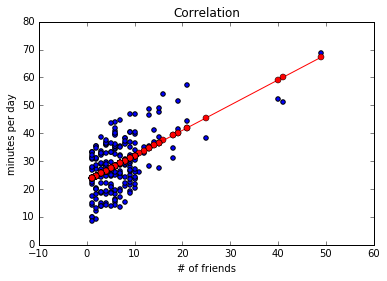

In [52]:
def show_correlation(x, y):
    plt.scatter(x, y)
    predicts = [predict(alpha, beta, x_i) for x_i in x]
    plt.plot(x, predicts, color='red', marker='o', linestyle='solid')
    plt.title("Correlation")
    plt.xlabel("# of friends")
    plt.ylabel("minutes per day")
    
    plt.show()
    
show_correlation(num_friends_good, daily_minute_good)

We need a better way to figure out how well we’ve fit the data than staring at the graph. 
A common measure is the **coefficient of determination** (or R-squared), which measures the fraction of the total variation in the dependent variable that is captured by the model:

In [58]:
def de_mean(x):
    x_bar = numpy.mean(x)
    return [x_i - x_bar for x_i in x]


def total_sum_of_squares(y):
    """the total squared variation of y_i's from their mean"""
    return sum(v ** 2 for v in de_mean(y))

def r_squared(alpha, beta, x, y):
    """the fraction of variation in y captured by the model, which equals 
    1 - the fraction of variation in y not captured by the model"""

    return 1.0 - (sum_of_squared_errors(alpha, beta, x, y) / total_sum_of_squares(y))
    
r_squared(alpha, beta, num_friends_good, daily_minute_good)

0.3291078377836304

Now, we chose the alpha and beta that minimized the sum of the squared prediction errors.

## Using Gradient Descent

If we write theta = [alpha, beta] , then we can also solve this using gradient descent:

In [65]:
import random

def squared_error(x_i, y_i, theta):
    alpha, beta = theta
    return error(alpha, beta, x_i, y_i) ** 2

def squared_error_gradient(x_i, y_i, theta):
    alpha, beta = theta
    return [-2 * error(alpha, beta, x_i, y_i), # alpha partial derivative
            -2 * error(alpha, beta, x_i, y_i) * x_i] # beta partial derivative

def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]
        
def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]     

def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

# choose random value to start
random.seed(0)
theta = [random.random(), random.random()]
alpha, beta = minimize_stochastic(squared_error, squared_error_gradient, num_friends_good, 
                                  daily_minute_good, theta, 0.0001)

In [66]:
print("alpha ", alpha)
print("beta", beta)

alpha  22.93746417548679
beta 0.9043371597664965


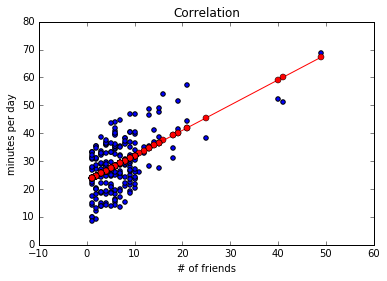

In [67]:
show_correlation(num_friends_good, daily_minute_good)

In [68]:
r_squared(alpha, beta, num_friends_good, daily_minute_good)

0.32910726440432503